# Auxiliary Functions

In this section the auxiliary functions used in this project are implemented.

For this project, 2 Python helper modules were also implemented under jupyter/modules folder:

    - TextProcessor: Which has the methods to process the text using the approaches used in this project.
    - JsonHelper: It was used to convert dictionaries into JSON format.
    
The reason to separate these modules from the Jupyter notebooks was to keep the code organised and to follow the best programming practices with regards to reuse and code modularization.

In [151]:
# adding modules folder to the path
import sys
sys.path.append('./modules')

# importing constants and modules created for this project
from constants import *
from text_processor import *

# importing modules specific to this notebook
import logging
import pandas as pd
#import altair as alt
#import seaborn as sns
import random
import concurrent.futures
import matplotlib.pyplot as plt
import zipfile
from wordcloud import WordCloud
from dotenv import dotenv_values
from nltk.probability import FreqDist
from tqdm import tqdm
from datetime import datetime, timedelta
from IPython.display import Image

from sklearn.ensemble import RandomForestRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from sklearn.metrics import mean_squared_error

# use a logger to help debugging
logger = logging.getLogger('ca2-jupyter')

# set logger level
logger.setLevel(logging.ERROR)

def unzip_file(zip_path, extract_path):
    '''
    Auxiliary function to unzip files.

    Parameters:
        zip_path     (str): Zip file path.
        extract_path (str): Path to unzip.
    '''
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

def wordcloud_draw(data, color='black'):
    '''
    Auxiliary function to generate a word cloud from the data.

    Parameters:
        data (DataFrame): Data frame to be processed.
        color      (str): Background color.
    '''
    words = ' '.join(data)
    wordcloud = WordCloud(background_color=color, width=2500, height=2000).generate(words)
    wordcloud.to_file(join(IMAGES_FOLDER, TWEETS_WORD_CLOUD))
    plt.figure(1,figsize=(10, 10))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

def process_tweets_chunk(chunk):
    """
    Auxiliary method to process the tweets from the input list.
    
    It processes the tweets, extracting their sentiment during the process.
    
    It generates a table with the following columns:

        'tweet_raw', 'sent_raw', 'tweet_clr', 'sent_clr', 'tweet_st', 'sent_st', 'tweet_lm', 'sent_lm'
    
    Parameters:
        tweets_list (lst): List of tweets to be processed.
    Returns:
        tweets_df (DataFrame): Data frame with the processed data.
    """
    proc_tweets = []
    for tweet in chunk:
        tweet_raw = tweet
        sentiment_raw = TextProcessor.get_sentiment(tweet_raw)

        tweet_str = TextProcessor.clean_text(tweet_raw)
        sentiment_str = TextProcessor.get_sentiment(tweet_str)

        tweet_clr = TextProcessor.process_text(tweet_raw)
        sentiment_clr = TextProcessor.get_sentiment(tweet_clr)

        tweet_st = TextProcessor.process_text(tweet_raw, use_stemmer=True)
        sentiment_st = TextProcessor.get_sentiment(tweet_st)

        tweet_lm = TextProcessor.process_text(tweet_raw, use_lemmatizer=True)
        sentiment_lm = TextProcessor.get_sentiment(tweet_lm)

        proc_tweets.append((tweet_raw, sentiment_raw, tweet_str, sentiment_str, tweet_clr, sentiment_clr, tweet_st, sentiment_st, tweet_lm, sentiment_lm))

    return proc_tweets

def process_tweets_async(tweets_list, chunk_size=1000):
    """
    Auxiliary method to process the tweets async in chunks using the process_tweets_chunk function.
    
    It uses threads to process the block of tweets concurrently.
      
    Parameters:
        tweets_list (lst): List of tweets to be processed.
        chunk_size (int): The size of the chunks.
    Returns:
        tweets_df (DataFrame): Data frame with the processed data.
    """
    proc_tweets = []
    num_chunks = (len(tweets_list) + chunk_size - 1) // chunk_size

    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for i in range(num_chunks):
            chunk = tweets_list[i*chunk_size:(i+1)*chunk_size]
            future = executor.submit(process_tweets_chunk, chunk)
            futures.append(future)

        for future in tqdm(concurrent.futures.as_completed(futures), total=num_chunks, desc='Processing'):
            proc_tweets.extend(future.result())

    tweets_df = pd.DataFrame(proc_tweets, columns=['tweet_raw', 'sent_raw', 'tweet_str', 'sent_str', 'tweet_clr', 'sent_clr', 'tweet_st', 'sent_st', 'tweet_lm', 'sent_lm'])

    return tweets_df

def generate_random_timestamps_dataframe(year, num_dates):
    """
    Generate a DataFrame with sequential dates with several ramdom timestamps per day for a given year.

    Parameters:
        year (int): The year for which to generate the sequential dates.
        num_dates (int): The number of sequential dates to generate.
    Returns:
        DataFrame: A DataFrame containing the one year dates with random timestamps.
    """
    start_date = datetime(year, 1, 1)
    date_range = [start_date + timedelta(days=i) for i in range(365)]
    timestamp_per_day = int(num_dates/365)
    
    timestamps = []
    for date in date_range:
        timestamp_range = [date + timedelta(hours=random.randint(0, 23),
                                            minutes=random.randint(0, 59),
                                            seconds=random.randint(0, 59)) for _ in range(timestamp_per_day)]
        timestamps.extend(timestamp_range)

    df = pd.DataFrame({'Timestamp': timestamps})
    return df

# Getting Data From Hadoop (VM)

In this step, Pyspark was used to retrieve the dataset from the Hadoop environment.

This process was implemented to demonstrate how a large dataset could be obtained from a distributed big data platform.

In this environment, Hadoop is hosted in a local VM, this way, due to hardware limitations, only this step of data acquisition was executed in the VM.

The rest of this Jupyter notebook can run independetly of this step, since the dataset was also stored locally in a csv file.

For this step to run properly, it was assumed that the following operations were performed previously in a terminal:

    1. Hadoop was started in the VM

    2. The dataset files was saved in the HDFS by using the commands:

         hadoop fs -put ./tweets_raw.csv /user1
         hadoop fs -put ./tweets_sentiment.csv /user1

In this experiment, the two datasets with the raw tweets and the one with the calculated sentiment were manipulated using PySpark.

The data was loaded into a data frame from the Hadoop environment using the API.

In [1]:
# importing pyspark libs
from pyspark.sql.types import *
from pyspark.sql.functions import when

In [2]:
# building the dataset schema
tweets_raw_cols = ['', 'userid', 'username', 'acctdesc', 'location', 'following', 'followers', 'totaltweets', 'usercreatedts', 'tweetid', 'tweetcreatedts', 'retweetcount', 'text', 'hashtags', 'language', 'coordinates', 'favorite_count', 'extractedts']

col_type = [StructField(col, StringType(), True) for col in tweets_raw_cols]

tweet_raw_scheme = StructType(col_type)

# retrieving the data from the local hadoop environment
tweets_raw_df = spark.read.load('hdfs://localhost:9000/user1/tweets_raw.csv', format="csv", header="true", sep=',', schema=tweet_raw_scheme)

# printing the schema
tweets_raw_df.printSchema()

root
 |-- : string (nullable = true)
 |-- userid: string (nullable = true)
 |-- username: string (nullable = true)
 |-- acctdesc: string (nullable = true)
 |-- location: string (nullable = true)
 |-- following: string (nullable = true)
 |-- followers: string (nullable = true)
 |-- totaltweets: string (nullable = true)
 |-- usercreatedts: string (nullable = true)
 |-- tweetid: string (nullable = true)
 |-- tweetcreatedts: string (nullable = true)
 |-- retweetcount: string (nullable = true)
 |-- text: string (nullable = true)
 |-- hashtags: string (nullable = true)
 |-- language: string (nullable = true)
 |-- coordinates: string (nullable = true)
 |-- favorite_count: string (nullable = true)
 |-- extractedts: string (nullable = true)



In [3]:
# showing the first 5 rows
tweets_raw_df.show(5)

+--------------------+--------------------+--------+--------------------+--------+--------------------+---------+-----------+--------------------+-------------------+--------------------+------------+--------------------+--------+--------+-----------+--------------+-----------+
|                    |              userid|username|            acctdesc|location|           following|followers|totaltweets|       usercreatedts|            tweetid|      tweetcreatedts|retweetcount|                text|hashtags|language|coordinates|favorite_count|extractedts|
+--------------------+--------------------+--------+--------------------+--------+--------------------+---------+-----------+--------------------+-------------------+--------------------+------------+--------------------+--------+--------+-----------+--------------+-----------+
|                   0|            16882774| Yaniela|Animal lover, sup...|  Hawaii|                1158|      392|      88366|2008-10-21 07:34:...|15096819500421980

Getting the data from the sentiment dataset to add a new collumn with the index that represent each sentiment:
- Negative: 0
- Neutral: 1
- Positive: 2

In [4]:
# building the dataset schema
tweets_sent_cols = ['tweet_raw', 'sent_raw', 'tweet_str', 'sent_str', 'tweet_clr', 'sent_clr', 'tweet_st', 'sent_st', 'tweet_lm', 'sent_lm']

col_type = [StructField(col, StringType(), True) for col in tweets_sent_cols]

tweet_sent_schema = StructType(col_type)

# retrieving the data from the local hadoop environment
tweets_sent_df = spark.read.load('hdfs://localhost:9000/user1/tweets_sentiment.csv', format="csv", header="true", sep=',', schema=tweet_sent_schema)

# using pyspark function to create a new column with the index of the sentiment
tweets_sent_df = tweets_sent_df.withColumn("sent_clr_index", when(tweets_sent_df.sent_clr == "neutral", "1")
                                                            .when(tweets_sent_df.sent_clr == "positive","2")
                                                            .otherwise("0"))
tweets_sent_df[['sent_clr_index', 'sent_clr']].show(5)

+--------------+--------+
|sent_clr_index|sent_clr|
+--------------+--------+
|             1| neutral|
|             0|    null|
|             1| neutral|
|             1| neutral|
|             1| neutral|
+--------------+--------+
only showing top 5 rows



# Data Storage on MongoDB (VM)

In this step, the datasets obtaiend from the Hadoop environment were stored in MongoDB.

This step was also implemented to demonstrate how a large dataset could be manipulated using a NoSQL database.

To execute this step, it is assumed that an instance of MongoDB is running on the system.

For this experiment, a VM was prepared with MongoDB environment previously configured.

The rest of this Jupyter notebook can run independetly of this step, since the datasets were also stored locally in a csv file.

In [5]:
#pip install pymongo==3.11.4

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [6]:
#!pip install pandas pymongo
from pymongo import MongoClient
import pandas as pd

In [7]:
# limiting the size for performance reasons
tweets_raw_mongo_df = tweets_raw_df.limit(1000)

In [8]:
# mongodb connection details
mongodb_uri = 'mongodb://localhost:27017/'
database_name = 'cct-ca2'
collection_name = 'twitter'

# connect to mongodb
client = MongoClient(mongodb_uri)
db = client[database_name]
collection = db[collection_name]

# convert data to a list of dictionaries
data_dict = [row.asDict() for row in tweets_raw_mongo_df.rdd.collect()]

# insert data into database
collection.insert_many(data_dict)

# close connection
client.close()

# Sentiment Analysis and Time-Series Forecast

The dataset used was obtained from a <a href="https://www.kaggle.com/code/ssaisuryateja/eda-and-sentiment-analysis/input">Kaggle repository</a> and it is about Twitter's users comments on the war in Ukraine in 2022.

This large dataset was processed for sentiment analysis and time-series to forcast the sentiment of tweets over a period of time.

The following sections cover the EDA steps and the sentiment and time-series analysis.

## Data Pre-Processing

In this step the raw data was collected from the zip files that contain the csv datasets.

As part of this step, it was handled null values and the columns were properly converted into their data types.

In [152]:
# zip files with the dataset
tweets_raw_zip = join(DATASETS_FOLDER, 'tweets_raw.zip')
tweets_sent_zip = join(DATASETS_FOLDER, 'tweets_sentiment.zip')

# unzip the files
unzip_file(tweets_raw_zip, DATASETS_FOLDER)
unzip_file(tweets_sent_zip, DATASETS_FOLDER)

In [153]:
# getting tweets from the archive
dataset = pd.read_csv(TWEETS_DS_RAW, encoding='utf-8')

# dataset column names
tweets_cols = ['username', 'tweetid', 'text', 'hashtags', 'language', 'extractedts']

# storing the dataset in a variable for processing
tweets_df = dataset[tweets_cols]

# converting date column into proper date type
tweets_df['extractedts'] = pd.to_datetime(tweets_df['extractedts'])

# data size
print(f'Dataset size: {len(tweets_df)}')

Dataset size: 364875


In [154]:
# checking for null values
pd.DataFrame(tweets_df.isnull().sum(), columns=['Null Values'])

,Null Values
username,0
tweetid,0
text,0
hashtags,0
language,0
extractedts,0


In [155]:
# describing the data
tweets_df.describe(include='all')

,username,tweetid,text,hashtags,language,extractedts
count,364875,3.648750e+05,364875,364875,364875,364875
unique,166400,NaN,104548,85962,61,364875
top,FuckPutinBot,NaN,⚡The Ukrainian Air Force would like to address...,[],en,2022-04-01 00:44:20.097867
freq,789,NaN,7297,72345,254626,1
first,NaN,NaN,NaN,NaN,NaN,2022-04-01 00:01:44.294934
last,NaN,NaN,NaN,NaN,NaN,2022-04-02 00:46:57.116538
mean,NaN,1.509875e+18,NaN,NaN,NaN,NaN
std,NaN,9.829062e+13,NaN,NaN,NaN,NaN
min,NaN,1.509682e+18,NaN,NaN,NaN,NaN
25%,NaN,1.509795e+18,NaN,NaN,NaN,NaN


The original dataset covers only a short period of time as shown below.

In [156]:
# showing the date covereage in this dataset
tweets_df['extractedts'].min(), tweets_df['extractedts'].max()

(Timestamp('2022-04-01 00:01:44.294934'),
 Timestamp('2022-04-02 00:46:57.116538'))

This way, for the sake of the experimentation proposed in the brief of this project, a syntetic Timestamp column was generated to cover the period of one year.

Although this change affects the analysis of the data in terms of reality, as the timestamps are artifitial, it doesn't affect the outcome of the project.

Thus, the strategy used was to create one year of sequential dates with random timestamps that cover the whole year of 2022.

In [157]:
# generate random dates covering the period of one year
random_dates_column = generate_random_timestamps_dataframe(2022, len(tweets_df))

# displaying the first entries
random_dates_column.head()

,Timestamp
0,2022-01-01 08:45:58
1,2022-01-01 05:50:33
2,2022-01-01 03:43:01
3,2022-01-01 06:57:33
4,2022-01-01 05:37:57


This way, the tweets dataset are now covering one year period as expected. 

In [158]:
# showing the date covereage in this dataset
random_dates_column['Timestamp'].min(), random_dates_column['Timestamp'].max()

(Timestamp('2022-01-01 00:01:11'), Timestamp('2022-12-31 23:57:10'))

In [159]:
# checking there are only 365 days in the dates column
len(random_dates_column['Timestamp'].dt.date.unique())

365

## Text Processing for Sentiment Analysis

For this project, the raw tweets were processed and the following columns were generated:

    tweet_raw, sent_raw: Original tweets + sentiment.

    tweet_str, sent_str: Tweets after the removal of special characters + sentiment.

    tweet_clr, sent_clr: Tweets after the removal of special characters and stop words + sentiment.

    tweet_st, sent_st: Tweets after the removal of special characters, stop words and application of Porter Stemmer + sentiment.

    tweet_lm, sent_lm: Tweets after the removal of special characters, stop words and application of Lemmatizer + sentiment.

The sentiment was calculated for each version of the tweet because it was observed the results were different.

The algorithm used to extract the sentiment from the Tweets were obtained from TextBlob. The possible sentiments were: positive, negative and neutral.

Since this is a time consuming process, the tweets were processed previously and stored in a csv file in the datasets folder.

So, the next code block can be skipped as the processed tweets will be obtained directly from the csv file.

In [70]:
# NOTE: YOU CAN SKIP THIS CODE BLOCK.
# ONLY RUN THIS CODE IF YOU WANT TO RE-CALCULATE THE SENTIMENT OF THE RAW TWEETS
# THIS IS TIME-CONSUMING SO EVEN WITH A MULTI-THREAD STRATEGY TO PROCESS THE TWEETS 
# IN CHUNKS IT TAKES A LONG TIME TO FINISH.

# getting the tweets list from the dataframe
tweets_list = tweets_df['text'].values

# processing retrieved data using text processing
tweets_proc = process_tweets_async(tweets_list)

# creating a csv file in the output folder for the full dataset
tweets_proc.to_csv(TWEETS_SENT, index=False)

# display the first rows
tweets_proc.head()

Processing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 365/365 [53:19<00:00,  8.77s/it]


,tweet_raw,sent_raw,tweet_str,sent_str,tweet_clr,sent_clr,tweet_st,sent_st,tweet_lm,sent_lm
0,#Ukraine: Another Russian BTR-82A lost during ...,neutral,ukraine another russian btr a lost during u...,neutral,ukraine another russian btr lost ukrainian adv...,neutral,ukrain anoth russian btr lost ukrainian advanc...,neutral,ukraine another russian btr lost ukrainian adv...,neutral
1,#Biden's plan would be accompanied by a diplom...,negative,biden s plan would be accompanied by a diploma...,negative,biden plan would accompanied diplomatic push i...,neutral,biden plan would accompani diplomat push inter...,neutral,biden plan would accompanied diplomatic push i...,neutral
2,(1/3) 🇷🇺🇮🇹 Il 30 marzo 2022 su iniziativa dell...,neutral,il marzo su iniziativa dell...,neutral,il marzo su iniziativa della parte italiana si...,neutral,il marzo su iniziativa della part italiana si ...,neutral,il marzo su iniziativa della parte italiana si...,neutral
3,"@Abiy Ahmed, Eritrean dictator Isaias Afewerki...",neutral,ahmed eritrean dictator isaias afewerki and ...,neutral,ahmed eritrean dictator isaias afewerki amhara...,neutral,ahm eritrean dictat isaia afewerki amhara alli...,positive,ahmed eritrean dictator isaias afewerki amhara...,neutral
4,I’m on a longer assignment in #Warsaw #Poland ...,neutral,i m on a longer assignment in warsaw poland co...,neutral,longer assignment warsaw poland covering refug...,neutral,longer assign warsaw poland cover refuge ukrai...,neutral,long assignment warsaw poland covering refugee...,negative


In [160]:
# getting tweets from the archive
tweets_proc = pd.read_csv(TWEETS_SENT, encoding='utf-8')

# size of the data
print(f'{len(tweets_proc)}')

# display the first rows
tweets_proc.head()

364875


,tweet_raw,sent_raw,tweet_str,sent_str,tweet_clr,sent_clr,tweet_st,sent_st,tweet_lm,sent_lm
0,#Ukraine: Another Russian BTR-82A lost during ...,neutral,ukraine another russian btr a lost during u...,neutral,ukraine another russian btr lost ukrainian adv...,neutral,ukrain anoth russian btr lost ukrainian advanc...,neutral,ukraine another russian btr lost ukrainian adv...,neutral
1,#Biden's plan would be accompanied by a diplom...,negative,biden s plan would be accompanied by a diploma...,negative,biden plan would accompanied diplomatic push i...,neutral,biden plan would accompani diplomat push inter...,neutral,biden plan would accompanied diplomatic push i...,neutral
2,(1/3) 🇷🇺🇮🇹 Il 30 marzo 2022 su iniziativa dell...,neutral,il marzo su iniziativa dell...,neutral,il marzo su iniziativa della parte italiana si...,neutral,il marzo su iniziativa della part italiana si ...,neutral,il marzo su iniziativa della parte italiana si...,neutral
3,"@Abiy Ahmed, Eritrean dictator Isaias Afewerki...",neutral,ahmed eritrean dictator isaias afewerki and ...,neutral,ahmed eritrean dictator isaias afewerki amhara...,neutral,ahm eritrean dictat isaia afewerki amhara alli...,positive,ahmed eritrean dictator isaias afewerki amhara...,neutral
4,I’m on a longer assignment in #Warsaw #Poland ...,neutral,i m on a longer assignment in warsaw poland co...,neutral,longer assignment warsaw poland covering refug...,neutral,longer assign warsaw poland cover refuge ukrai...,neutral,long assignment warsaw poland covering refugee...,negative


## Dataset Concatenation

In this step the dataset is combined so all the tweets have their sentiment and artificial timestamps allocated properly.

As part of this step, the null values are also removed from the combined dataset.

In [161]:
len(tweets_df), len(tweets_proc), len(random_dates_column)

(364875, 364875, 364635)

In [162]:
# concatenate the sentiment and the original dataset
tweets_final = pd.concat([tweets_df, tweets_proc, random_dates_column], axis=1)

print(f'{len(tweets_final)}')

# independent variables to be tested from the dataset
X_names = ['tweet_str', 'tweet_clr', 'tweet_st', 'tweet_lm']
# target variables for each column to be tested
y_names = ['sent_str', 'sent_clr', 'sent_st', 'sent_lm']
# ramdom date
col_date = ['Timestamp']

# keeping only the relevant columns for the analysis
col_names = X_names + y_names + col_date
tweets_final = tweets_final[col_names].sort_values(by='Timestamp')
tweets_final.head()

364875


,tweet_str,tweet_clr,tweet_st,tweet_lm,sent_str,sent_clr,sent_st,sent_lm,Timestamp
548,warmaps ukraine,warmaps ukraine,warmap ukrain,warmaps ukraine,neutral,neutral,neutral,neutral,2022-01-01 00:01:11
989,non fermi putin perch biden non vuole la pac...,non fermi putin perch biden non vuole la pace ...,non fermi putin perch biden non vuol la pace s...,non fermi putin perch biden non vuole la pace ...,neutral,neutral,neutral,neutral,2022-01-01 00:01:57
952,new ukraine needs better air defense systems ...,new ukraine needs better air defense systems e...,new ukrain need better air defens system excus...,new ukraine needs good air defense systems exc...,positive,positive,positive,positive,2022-01-01 00:02:49
455,one year ago ukraine,one year ago ukraine,one year ago ukrain,one year ago ukraine,neutral,neutral,neutral,neutral,2022-01-01 00:03:55
699,this is a new wrinkle that sadly sounds absol...,new wrinkle sadly sounds absolutely accurate r...,new wrinkl sadli sound absolut accur requir re...,new wrinkle sadly sounds absolutely accurate r...,positive,positive,positive,positive,2022-01-01 00:04:02


In [163]:
# checking for null values
pd.DataFrame(tweets_final.isnull().sum(), columns=['Null Values'])

,Null Values
tweet_str,0
tweet_clr,2
tweet_st,2
tweet_lm,2
sent_str,0
sent_clr,0
sent_st,0
sent_lm,0
Timestamp,240


In [164]:
# removing null values
tweets_final = tweets_final.dropna()

# checking for null values
pd.DataFrame(tweets_final.isnull().sum(), columns=['Null Values'])

,Null Values
tweet_str,0
tweet_clr,0
tweet_st,0
tweet_lm,0
sent_str,0
sent_clr,0
sent_st,0
sent_lm,0
Timestamp,0


## Tweets Dataset Visualization

Word cloud are common ways to visualize text datasets, so it is possible to have an idea of its main content.

The word cloud below was generated over the cleaned tweets after the removal of special characters and stop words.

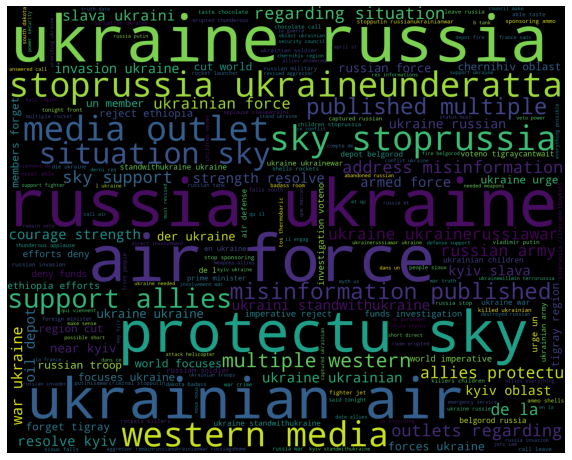

In [15]:
#wordcloud_draw(tweets_final['tweet_clr'])
Image(filename=join(IMAGES_FOLDER, TWEETS_WORD_CLOUD))

In [165]:
# get the count of users expressing a particular sentiment (neutral, pos or neg)
# from the dataset
for sent in y_names:
    # group data by sentiment
    grouped_df = tweets_final.groupby(sent)

    # count the number of rows with that sentiment
    count_values = grouped_df[sent].count()

    # print the resulting aggregated data
    print(count_values)

sent_str
negative     58350
neutral     187658
positive    118625
Name: sent_str, dtype: int64
sent_clr
negative     59894
neutral     203118
positive    101621
Name: sent_clr, dtype: int64
sent_st
negative     48908
neutral     230836
positive     84889
Name: sent_st, dtype: int64
sent_lm
negative     63110
neutral     200654
positive    100869
Name: sent_lm, dtype: int64


Overall, the diferent text processing techniques applied to the raw tweets didn't change the big picture, which shows more neutral comments about the war than positives or negatives.

This sentiment analysis alone cannot explain what happend with this particular dataset, as it can't be garanteed that all tweets are making judgements about the war, for example.

While this dataset contains only tweets about this topic, several subjects can be talked about in social media, which makes it hard to extract more information from with regards to what is the feeling of the people towards the conflict.

## Time-Series Forecast

For the time-series forecast the sentiment calculated over the cleaned tweets (tweet_clr) will be used, which refers to the sent_clr column in the dataset.

In [166]:
# possible sentiments in the dataset
sentiment_lst = ['negative', 'neutral', 'positive']

# converting the string sentiment into numerical value
tweets_final['sent_clr_index'] = tweets_final['sent_clr'].apply(lambda x: sentiment_lst.index(x))

# show the result
tweets_final[['Timestamp', 'tweet_clr', 'sent_clr', 'sent_clr_index']].head()

,Timestamp,tweet_clr,sent_clr,sent_clr_index
548,2022-01-01 00:01:11,warmaps ukraine,neutral,1
989,2022-01-01 00:01:57,non fermi putin perch biden non vuole la pace ...,neutral,1
952,2022-01-01 00:02:49,new ukraine needs better air defense systems e...,positive,2
455,2022-01-01 00:03:55,one year ago ukraine,neutral,1
699,2022-01-01 00:04:02,new wrinkle sadly sounds absolutely accurate r...,positive,2


In order to have an idea of how the sentiment of users fluctuate over the days on this topic, the following approach was taken:

- Get all sentiments per day from the dataset.
- Get the average sentiment for the day using the numerical value that represents the sentiments.
- Summarize the dataset by day and get the average value for the sentiment to represent the day.

In [167]:
# summaryze the data by date
grouped_df = tweets_final.groupby(tweets_final['Timestamp'].dt.date)['sent_clr_index'].mean().reset_index()
#grouped_df = df.groupby(df['Timestamp'].dt.date)['sent_clr_index'].agg(lambda x: x.mode()[0]).reset_index()

grouped_df.columns = ['date', 'sent_mean']

# Print the resulting aggregated data
grouped_df

,date,sent_mean
0,2022-01-01,1.197197
1,2022-01-02,1.166166
2,2022-01-03,1.194194
3,2022-01-04,1.151151
4,2022-01-05,1.206206
...,...,...
360,2022-12-27,1.112112
361,2022-12-28,1.152152
362,2022-12-29,1.118118
363,2022-12-30,1.151151


Use the last 20 days as testing data for the time series forecast. This is just for visualization purposes.

Train dates : 0 --- 344 (n=345)
Test dates : 345 --- 364 (n=20)


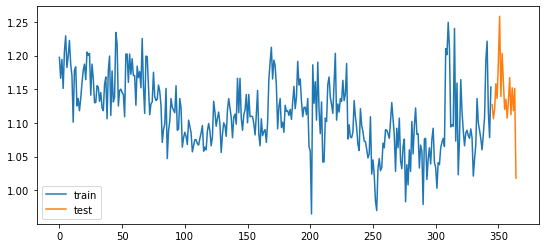

In [168]:
# parameters
steps = 20
y = 'sent_mean'

# split the data into train and test data for visualization
data_train = grouped_df[:-steps]
data_test = grouped_df[-steps:]

# print the train and test data details
print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()} (n={len(data_train)})")
print(f"Test dates : {data_test.index.min()} --- {data_test.index.max()} (n={len(data_test)})")

# plot the graph
fig, ax=plt.subplots(figsize=(9, 4))
data_train[y].plot(ax=ax, label='train')
data_test[y].plot(ax=ax, label='test')
ax.legend();

Make predictions at 1 week, 1 month and 3 months going forward.

Test error (mse) for 7 days: 0.0022833923951962663
Test error (mse) for 30 days: 0.002748363557980145
Test error (mse) for 90 days: 0.0023816288958755875


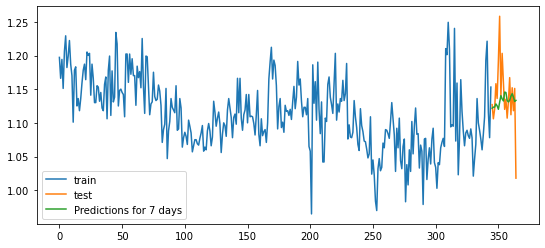

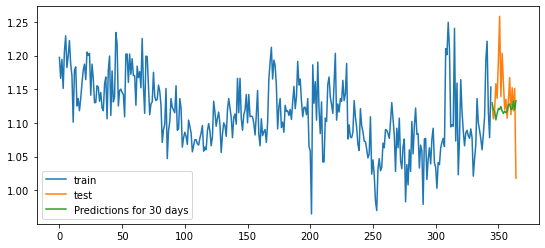

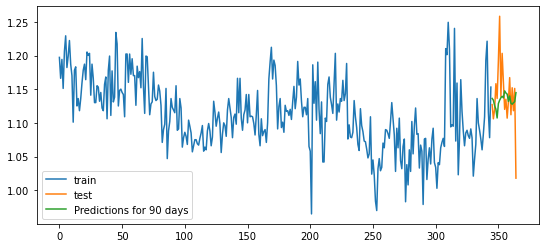

In [169]:
# using the following days as the lags parameter
pred_lags_days = [7, 30, 90]

# predict the data using the values above
for step in pred_lags_days:
    # instanciate forcaster
    forecaster = ForecasterAutoreg(regressor=RandomForestRegressor(random_state=42), lags=step)
    forecaster.fit(y=data_train[y])

    # make a prediction given the steps as input
    predictions = forecaster.predict(steps=steps)
    
    # plot the prediction in the graph
    fig, ax = plt.subplots(figsize=(9, 4))
    data_train[y].plot(ax=ax, label='train')
    data_test[y].plot(ax=ax, label='test')
    predictions.plot(ax=ax, label=f'Predictions for {step} days')
    ax.legend();
    
    # calculate the prediction error
    error_mse = mean_squared_error(y_true = data_test[y], y_pred = predictions)
    print(f"Test error (mse) for {step} days: {error_mse}")

In [ ]:
# auxiliary functions

In [136]:
forecaster = ForecasterAutoreg(regressor=RandomForestRegressor(random_state=42), lags=steps)
forecaster.fit(y=data_train[y])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=42) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
Transformer for y: None 
Transformer for exog: None 
Window size: 20 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 344] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2023-05-24 01:14:41 
Last fit date: 2023-05-24 01:14:41 
Skforecast version: 0.8.0 
Python version: 3.9.12 
Forecaster id: None 

In [139]:
# make a prediction given the steps as input
predictions = forecaster.predict(steps=steps)
predictions.head(5)

345    1.126557
346    1.115656
347    1.105105
348    1.105355
349    1.113854
Name: pred, dtype: float64

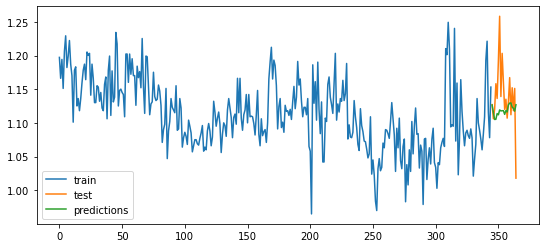

In [140]:
# plot the prediction in the graph
fig, ax = plt.subplots(figsize=(9, 4))
data_train[y].plot(ax=ax, label='train')
data_test[y].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [141]:
# calculate the prediction error
error_mse = mean_squared_error(y_true = data_test[y], y_pred = predictions)
print(f"Test error (mse): {error_mse}")

Test error (mse): 0.0027417201848451934


In [127]:
 # Hyperparameter Grid search
# ==============================================================================
steps = 20
forecaster = ForecasterAutoreg(regressor = RandomForestRegressor(random_state=123),lags = 12)

# Lags used as predictors
lags_grid = [10, 20]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
 'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
    forecaster = forecaster, 
    y = data_train['Mode'], 
    param_grid = param_grid, 
    lags_grid = lags_grid,
    steps = steps,
    refit = True,
    metric = 'mean_squared_error',
    initial_train_size = int(len(data_train)*0.5),
    fixed_train_size = False,
    return_best = True,
    verbose = False)


Number of models compared: 12.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 0.003252830354636733



In [128]:
 # Grid Search results
# ==============================================================================
results_grid

,lags,params,mean_squared_error,max_depth,n_estimators
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",0.003253,3,500
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",0.003265,5,500
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",0.003266,3,100
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",0.003360,10,500
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",0.003445,10,100
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",0.003455,5,100
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",0.003681,3,100
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 500}",0.003704,3,500
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.003715,5,100
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.003753,10,100


In [129]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressor = RandomForestRegressor(max_depth=3, n_estimators=500, random_state=123)
forecaster = ForecasterAutoreg(
 regressor = regressor,
 lags = 20
 )
forecaster.fit(y=data_train['Mode'])

In [130]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)

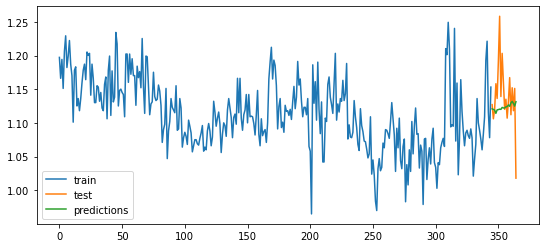

In [131]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['Mode'].plot(ax=ax, label='train')
data_test['Mode'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [132]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
 y_true = data_test['Mode'],
 y_pred = predictions
 )
print(f"Test error (mse): {error_mse}")

Test error (mse): 0.00257903815676723
